In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [14]:
df = pd.read_csv("data/labels_extra.csv")

In [22]:
df = df.dropna()
df = df.drop_duplicates()

In [23]:
df.head()

,image,type,subtype,label,set
0,100088800.png,Gussbeton,Pickelloch belueftet,Gussbeton / Pickelloch belueftet,train
1,100069600.png,Gussbeton,Pickelloch geschlossen,Gussbeton / Pickelloch geschlossen,train
2,100174700.png,Vollguss,Pickelloch belueftet,Vollguss / Pickelloch belueftet,train
3,100055100.png,Vollguss,Handgriff geschlossen,Vollguss / Handgriff geschlossen,train
4,100211100.png,Vollguss,Handgriff geschlossen,Vollguss / Handgriff geschlossen,train


In [21]:
df.shape

(2174, 5)

In [26]:
df.type.unique()

array(['Gussbeton', 'Vollguss', 'Rost', 'Andere'], dtype=object)

In [27]:
df.subtype.unique()

array(['Pickelloch belueftet', 'Pickelloch geschlossen',
       'Handgriff geschlossen', 'Strassenrost', 'Einlauf rund', '-',
       'Strassenrost gewoelbt', 'Handgriff seitlich', 'Handgriff mitte',
       'Handgriff geschlossen, verschraubt', 'Aufklappbar'], dtype=object)

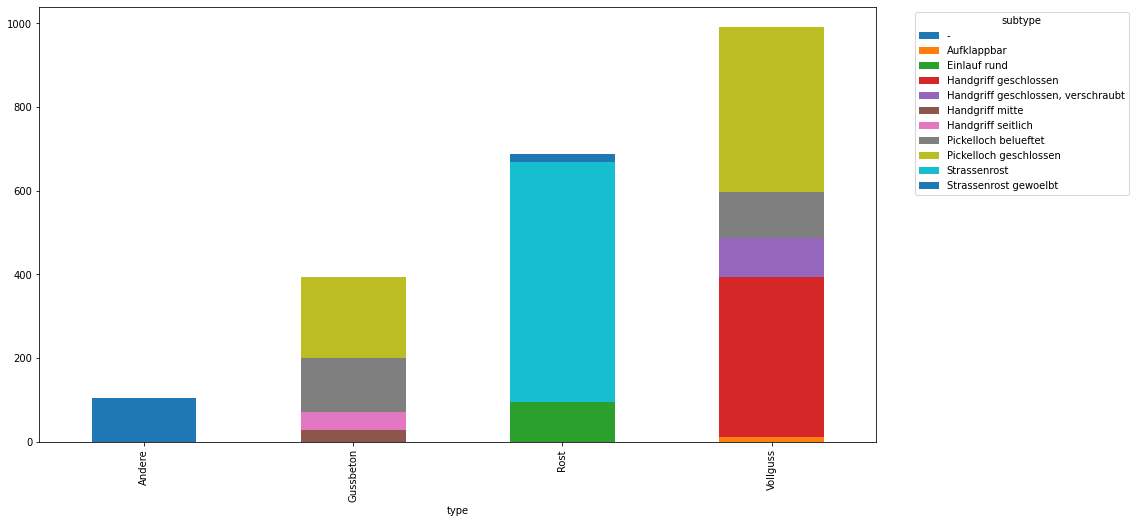

In [17]:
df_plot = df.groupby(['subtype', 'type']).size().reset_index().pivot(columns='subtype', index='type', values=0)
df_plot.plot(kind='bar', stacked=True,figsize=(15, 8))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",title="subtype")
plt.show()

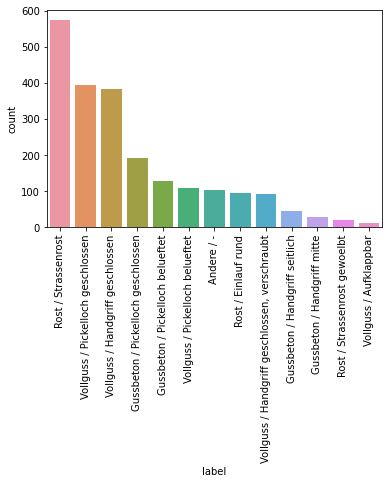

In [18]:
sns.countplot(x="label",data=df,order = df.label.value_counts().index)
plt.xticks(rotation = 90)
plt.show()

In [19]:
df.loc[df['label'] == "Vollguss / Aufklappbar"]

,image,type,subtype,label,set
182,100144000.png,Vollguss,Aufklappbar,Vollguss / Aufklappbar,test
330,100149600.png,Vollguss,Aufklappbar,Vollguss / Aufklappbar,train
828,100059700.png,Vollguss,Aufklappbar,Vollguss / Aufklappbar,val
903,100017200.png,Vollguss,Aufklappbar,Vollguss / Aufklappbar,train
995,100215800.png,Vollguss,Aufklappbar,Vollguss / Aufklappbar,train
1665,100065800.png,Vollguss,Aufklappbar,Vollguss / Aufklappbar,train
1672,100112700.png,Vollguss,Aufklappbar,Vollguss / Aufklappbar,train
1920,100160800.png,Vollguss,Aufklappbar,Vollguss / Aufklappbar,train
2046,100206100.png,Vollguss,Aufklappbar,Vollguss / Aufklappbar,train
2065,100129700.png,Vollguss,Aufklappbar,Vollguss / Aufklappbar,train


In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import KNNImputer

In [39]:
t_data = df[~df['type'].isna()]
orig_dt_X = df[['subtype']]
orig_dt_X = pd.get_dummies(orig_dt_X)
dt_X = KNNImputer(n_neighbors = 3).fit_transform(orig_dt_X)
dt_y = df['type']
dt_model = DecisionTreeClassifier(max_depth = 4).fit(dt_X, dt_y)


In [45]:
orig_dt_X

,subtype_-,subtype_Aufklappbar,subtype_Einlauf rund,subtype_Handgriff geschlossen,"subtype_Handgriff geschlossen, verschraubt",subtype_Handgriff mitte,subtype_Handgriff seitlich,subtype_Pickelloch belueftet,subtype_Pickelloch geschlossen,subtype_Strassenrost,subtype_Strassenrost gewoelbt
0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2169,0,0,0,0,0,0,0,0,1,0,0
2170,0,0,0,0,0,0,0,0,1,0,0
2171,0,0,1,0,0,0,0,0,0,0,0
2172,0,0,0,0,0,0,0,0,0,1,0


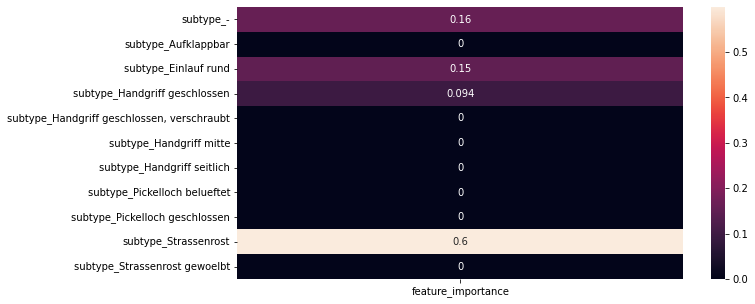

In [40]:
dt_features = pd.Series(dt_model.feature_importances_, index = orig_dt_X.columns, name = 'feature_importance')

plt.figure(figsize = (10, 5))
sns.heatmap(
	dt_features.to_frame(),
	annot = True
)
plt.show()

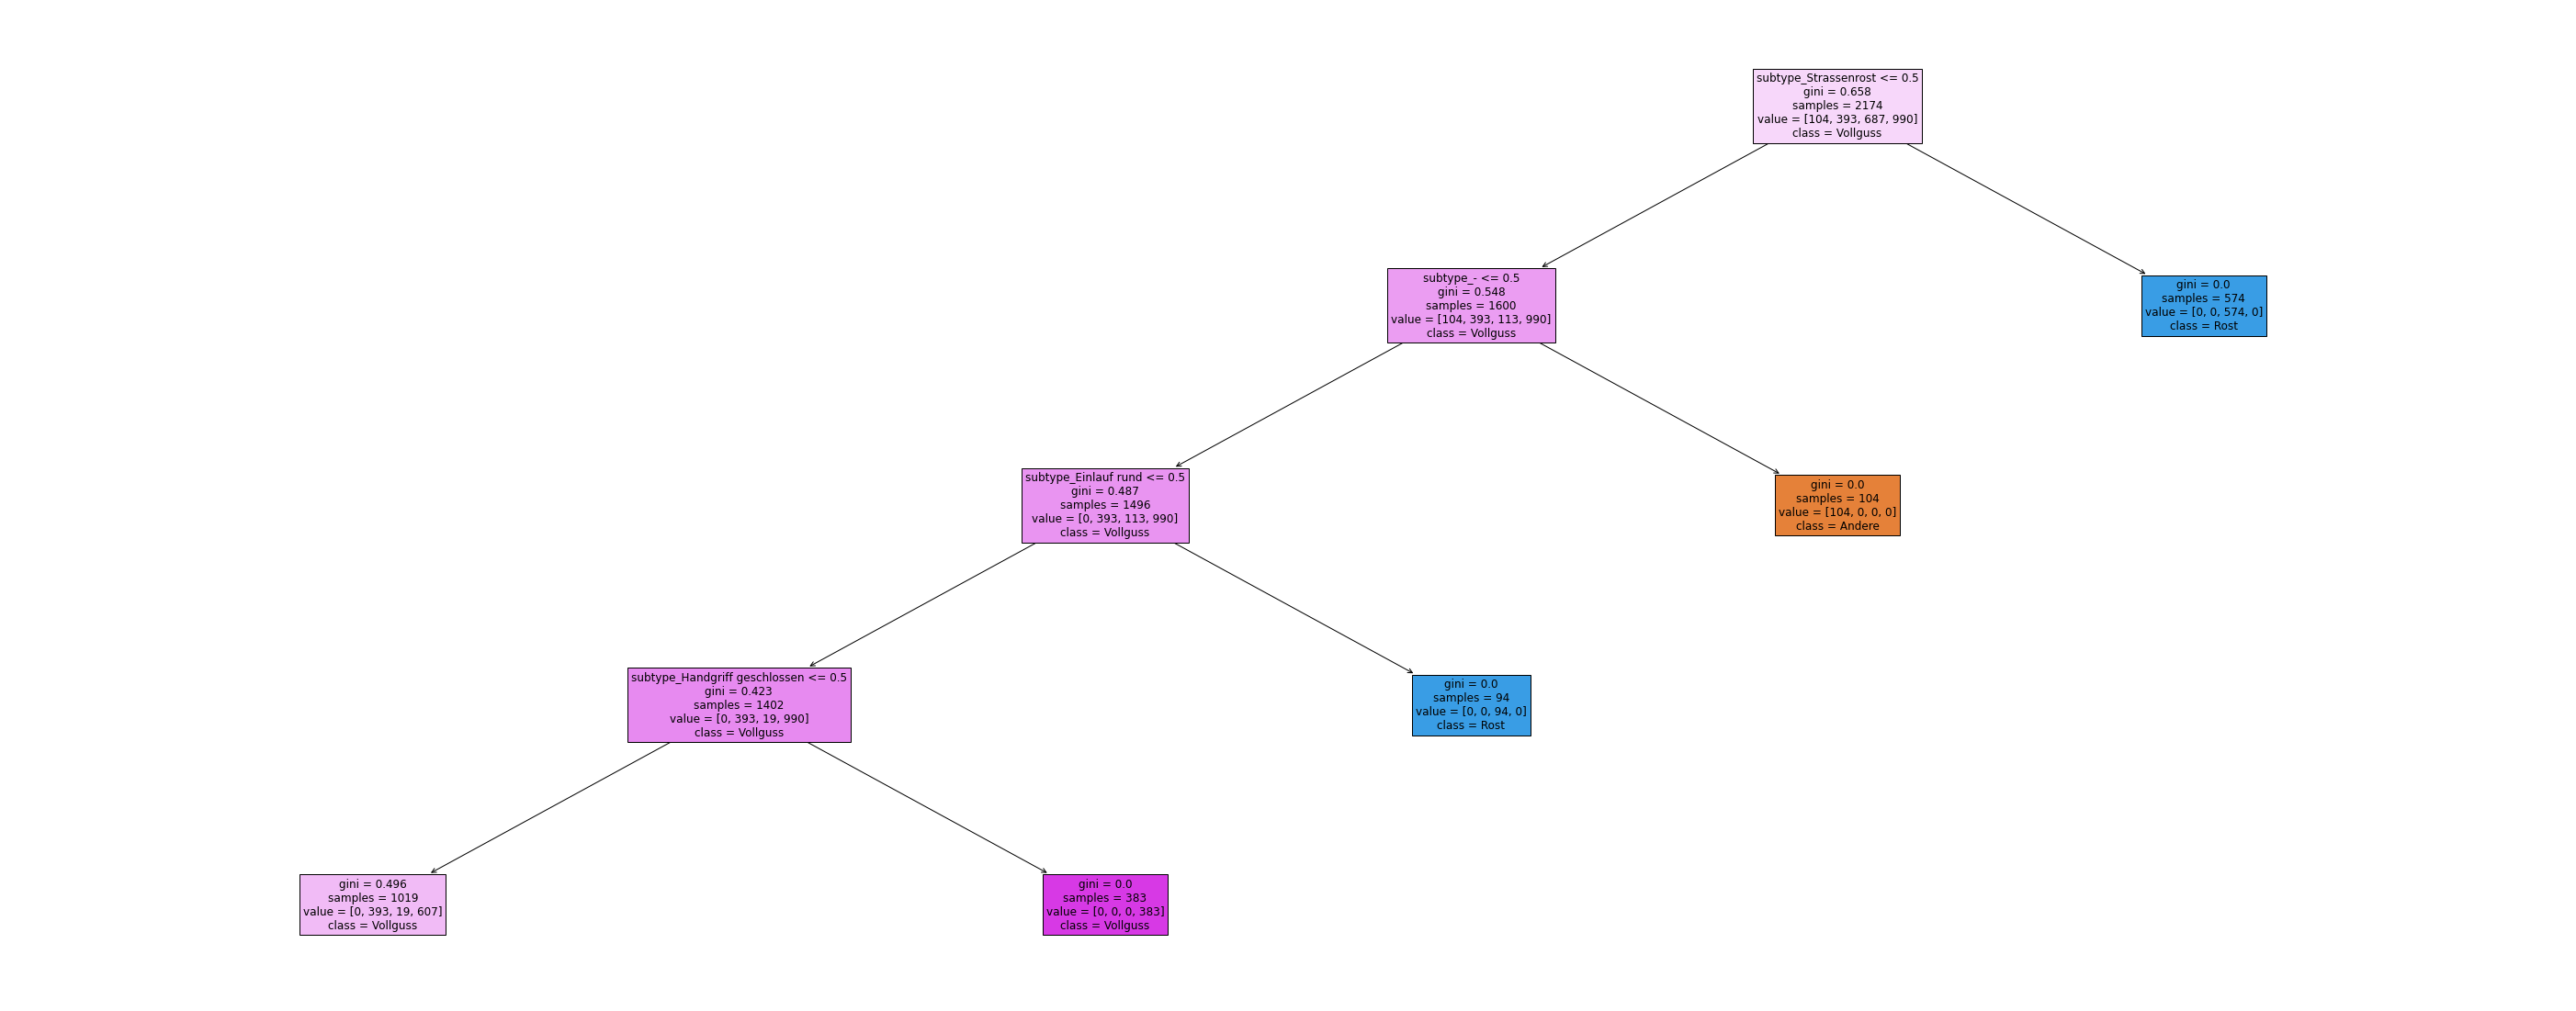

In [41]:
from sklearn.tree import plot_tree

plt.figure(figsize = (50, 20))
plot_tree(
	dt_model,
	max_depth = 4,
	feature_names = orig_dt_X.columns,
	class_names = dt_model.classes_,
	filled = True,
	fontsize = 12
)
plt.show()
